In [6]:
import tensorflow
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import cv2 as cv
from google.colab.patches import cv2_imshow

from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
print(cv.__version__)
print(tensorflow.__version__)
!python --version
import time

4.1.2
2.8.0
Python 3.7.12


## Get access to the drive

In [ ]:
#Susy's drive access below
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Change directory to load the data -- change back after it has been loaded!!!
import os
os.chdir("/content/drive/My Drive/2021_SusySu_Thesis")
!pwd
!ls

# Use a number of custom code files to make it easier to manipulate the data.
# This is the easiest way to make the modules accessible:
import sys
sys.path.append('./utils_revision')

/content/drive/My Drive/2021_SusySu_Thesis
 Coding				  Real_Time_Image
'ECE497_susy_Design Paper.gdoc'   Susy-RealTime_MNetCode6_100EpochsReLU.ipynb
 fer2013.csv			  Untitled1.ipynb
 presentation			  utils
 progress_SusySu_498.gdoc	  utils_revision
 Real-Image_recognition.ipynb


In [ ]:
# DEBUG
os.chdir("./utils_revision")
!ls

aug_datasets.py       grad_cam.py   my_model.h5		       preproc.py
data_augmentation.py  inference.py  output-onlinejpgtools.jpg  __pycache__
datasets.py	      MNV2	    preprocessor.py	       vizualizer.py


## Load and resize the real-time images
There are 4 conditions to predict and test accuracy: garbage images, long_distance images, normal images and unfull images.

Goal: to see how important it is to have the face_detection.

In [11]:
import numpy as np
import PIL
from imageio import imread

# This function makes the data uniformly distributed on [-1,1]
# -- we assume uniform on [0,255] coming in, then division by 255
# followed by subtraction and multiplication => [-1,1]

# normalization --> why we need to do the normalization towards the input image?

def preproc_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:

import os

# Function to convert the Grayscale Images to RGB by stacking


def aug_image(x):
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    return x


# Convert the entire Validation Set at once
def aug_val_data(x):
    num_samples = x.shape[0]
    x_data = [aug_image(im) for im in x[0:num_samples]]
    return np.array(x_data)



# Load the data here first

#load face from drive

def load_path(file_path):
  input_dir = file_path
  input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpeg') or fname.endswith('.jpg')  # can detect multiple type of images
    ]
  )
  return input_img_paths

def load_faces(file_path):
  input_img_paths = load_path(file_path)

  plt_face = []
  for i in input_img_paths:
    face = plt.imread(i)
    plt_face.append(face)
  return plt_face


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

#resize the image in 96*96*3 - grayscale
def transform_image_in_grayscale(image_path):
  width = 96
  height = 96 
  dim = (width, height)
  resized_real_face = cv.resize(image_path,dim,interpolation = cv.INTER_AREA)
  gray = rgb2gray(resized_real_face)
  resized_face_img = np.stack((gray,)*3, axis=-1)
  plt.imshow(resized_real_face)
  return resized_face_img


def resize_image(image_path):
  '''
  Transform the image into grayscale, 
  normalize image and expand image dimension to 96*96*3
  '''
  target_image = transform_image_in_grayscale(image_path)
  nor_image = preproc_input(target_image)
  nor_image = np.expand_dims(nor_image, axis=0)
  return nor_image



len of fi: 10
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/441635187967_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/451635187968_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/461635187969_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/471635187970_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/481635187971_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/691635188381_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/angry/701635188382_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_

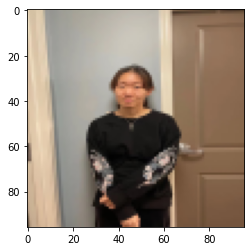

In [ ]:
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']

#load trained model
final_model_path = 'my_model.h5'   # load .hdf5 file in local google drive.
final_model_path_2 = '/content/drive/My Drive/2021_SusySu_Thesis/Coding/Irene_RT5_200_Final.hdf'
new_model = load_model(final_model_path)


file_path = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/1m/'

classes = []
predict_times_1m =[]
for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)

correct = 0
for i in range(len(classes)):
  resized = []
  path_name = load_path(classes[i]) # can be deleted if don't need to print path with image name out
  facial_image = load_faces(classes[i])
  print("len of fi:", len(facial_image))
  for j in facial_image:
    resized_image = resize_image(j)
    resized.append(resized_image)
  # predict the facial emotions
  for k in range(len(resized)):
      start_time = time.time()
      face = resized[k]
      y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
      y_pred1 = [np.argmax(prob) for prob in y_prob1]
      predict_time = time.time() - start_time
      predict_times_1m.append(predict_time)
      print("The predicted image emotion is: ", labels[y_pred1[0]], path_name[k])
      if (labels[y_pred1[0]] == labels[i]):
        correct += 1
accuracy = correct/(len(facial_image)*len(classes))
print(accuracy)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


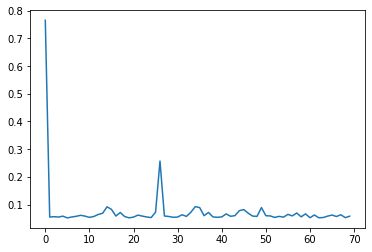

In [ ]:
import matplotlib.pyplot as plt
x= [i for i in range(len(predict_times_1m))]
plt.plot(x,predict_times_1m)

In [ ]:
print(sum(predict_times_1m) / len(predict_times_1m))

0.07462840080261231


['/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/angry', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/disgust', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/fear', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/happy', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/sad', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/surprise', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/neutral']
len of fi: 10
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/angry/1241635193259_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/angry/1251635193260_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/angry/1261635193261_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Im

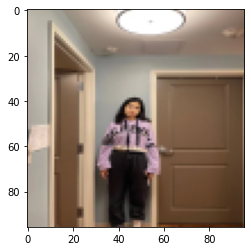

In [ ]:

labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']

#load trained model
final_model_path = 'my_model.h5'   # load .hdf5 file in local google drive.
final_model_path_2 = '/content/drive/My Drive/2021_SusySu_Thesis/Coding/Irene_RT5_200_Final.hdf'
new_model = load_model(final_model_path_2)
#new_model = load_model('2021_Zhebin_CSThesis.85-0.66.hdf5')

file_path = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/2m/'

classes = []

for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)

print(classes)


correct = 0
for i in range(len(classes)):
  resized = []
  path_name = load_path(classes[i]) # can be deleted if don't need to print path with image name out
  facial_image = load_faces(classes[i])
  print("len of fi:", len(facial_image))
  for j in facial_image:
    resized_image = resize_image(j)
    resized.append(resized_image)
  # predict the facial emotions
  for k in range(len(resized)):
      face = resized[k]
      y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
      y_pred1 = [np.argmax(prob) for prob in y_prob1]
      print("The predicted image emotion is: ", labels[y_pred1[0]], path_name[k])
      if (labels[y_pred1[0]] == labels[i]):
        correct += 1
accuracy = correct/(len(facial_image)*len(classes))
print(accuracy)

len of fi: 10
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/1291635194092_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/1301635194093_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/1311635194094_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/1321635194095_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/1331635194096_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/2141635195766_.pic.jpg
The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/angry/2151635195767_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Re

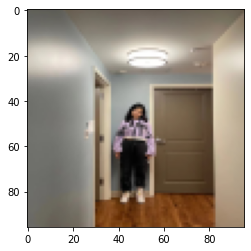

In [ ]:
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']

#load trained model
final_model_path = 'my_model.h5'   # load .hdf5 file in local google drive.
final_model_path_2 = '/content/drive/My Drive/2021_SusySu_Thesis/Coding/Irene_RT5_200_Final.hdf'
new_model = load_model(final_model_path)
#new_model = load_model('2021_Zhebin_CSThesis.85-0.66.hdf5')

file_path = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/3m/'

classes = []

for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)


correct = 0
for i in range(len(classes)):
  resized = []
  path_name = load_path(classes[i]) # can be deleted if don't need to print path with image name out
  facial_image = load_faces(classes[i])
  print("len of fi:", len(facial_image))
  for j in facial_image:
    resized_image = resize_image(j)
    resized.append(resized_image)
  # predict the facial emotions
  for k in range(len(resized)):
      face = resized[k]
      y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
      y_pred1 = [np.argmax(prob) for prob in y_prob1]
      print("The predicted image emotion is: ", labels[y_pred1[0]], path_name[k])
      if (labels[y_pred1[0]] == labels[i]):
        correct += 1
accuracy = correct/(len(facial_image)*len(classes))
print(accuracy)

['/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/angry', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/disgust', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/fear', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/happy', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/sad', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/surprise', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/neutral']
len of file: 2
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/angry/angry1.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/angry/angry2.jpg
len of file: 6
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/R

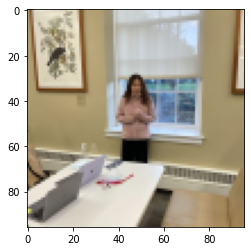

In [ ]:
file_path = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/long_distance_image/'

classes = []

for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)

print(classes)


for i in range(len(classes)):
  resized = []
  path_name = load_path(classes[i]) # can be deleted if don't need to print path with image name out
  facial_image = load_faces(classes[i])
  print("len of file:", len(facial_image))
  for j in facial_image:
    resized_image = resize_image(j)
    resized.append(resized_image)
  # predict the facial emotions
  for k in range(len(resized)):
      face = resized[k]
      y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
      y_pred1 = [np.argmax(prob) for prob in y_prob1]
      print("The predicted image emotion is: ", labels[y_pred1[0]], path_name[k])

The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1671634654303_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1681634654304_.pic.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1691634654305_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1701634654308_.pic.jpg
The predicted image emotion is:  surprise /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1711634654309_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1721634654310_.pic.jpg
The predicted image emotion is:  neutral /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/1731634654312_.pic.jpg
The predicted image emotion is:  happy /content/drive/

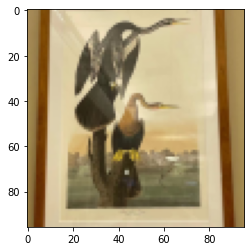

In [ ]:
file_path_garbage = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/garbage_image/'
#predict the facial emotions
image_name = load_path(file_path_garbage)

resized = []
facial_image = load_faces(file_path_garbage)
for i in range(len(facial_image)):
  resized_image = resize_image(facial_image[i])
  resized.append(resized_image)

# predict the facial emotions
for i in range(len(resized)):
    face = resized[i]
    y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
    y_pred1 = [np.argmax(prob) for prob in y_prob1]
    print("The predicted image emotion is: ", labels[y_pred1[0]], image_name[i])




The predicted image emotion is:  angry /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/angry1_mask.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/disgust1_mask.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/fear1_mask.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/happy1_mask.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/neutral1_mask.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/neutral2_mask.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/neutral3_mask.jpg
The predicted image emotion is:  happy /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/par

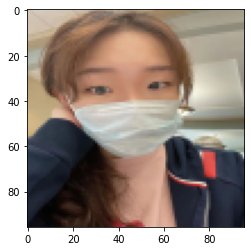

In [ ]:
file_path_partial = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/partial_image/'
#predict the facial emotions
image_name = load_path(file_path_partial)

resized = []
facial_image = load_faces(file_path_partial)
for i in range(len(facial_image)):
  resized_image = resize_image(facial_image[i])
  resized.append(resized_image)

# predict the facial emotions
for i in range(len(resized)):
    face = resized[i]
    y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
    y_pred1 = [np.argmax(prob) for prob in y_prob1]
    print("The predicted image emotion is: ", labels[y_pred1[0]], image_name[i])


['/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/angry', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/disgust', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/fear', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/happy', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/sad', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/surprise', '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/neutral']
len of file: 3
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/angry/1371634587955_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/angry/1411634587959_.pic.jpg
The predicted image emotion is:  sad /content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/angry/1421634587961_.pic.jpg

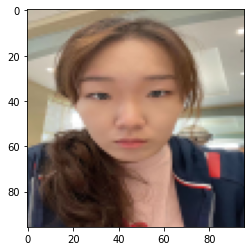

In [ ]:
file_path = '/content/drive/My Drive/2021_SusySu_Thesis/Real_Time_Image/normal_image/'

classes = []

for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)

print(classes)


for i in range(len(classes)):
  resized = []
  path_name = load_path(classes[i]) # can be deleted if don't need to print path with image name out
  facial_image = load_faces(classes[i])
  print("len of file:", len(facial_image))
  for j in facial_image:
    resized_image = resize_image(j)
    resized.append(resized_image)
  # predict the facial emotions
  for k in range(len(resized)):
      face = resized[k]
      y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
      y_pred1 = [np.argmax(prob) for prob in y_prob1]
      print("The predicted image emotion is: ", labels[y_pred1[0]], path_name[k])